In [27]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['savefig.dpi'] = 120 # Use 300 for PDF, 100 for slides
#InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

## Representing Data and Engineering Features

## Preprocessing

* Many of the algorithms that we've seen are greatly affected by _how_ you represent the training data
* Scaling, numeric/categorical values, missing values, feature selection/construction
* We typically need chain together different algorithms
    - Many preprocessing steps
    - Possibly many models
* This is called a _pipeline_ (or _workflow_)
* The best way to represent data depends not only on the semantics of the data, but also on the kind of model you are using. 
* For instance, linear models can learn better models by using different feature representations.

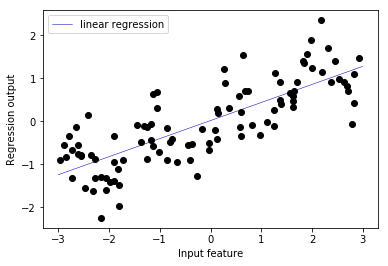

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

### Polynomials

We can also make linear models behave more flexibly by adding polynomials of the original continuous features. 

For a given feature x, we might want to consider $x^2$, $x^3$, $x^4$, and so on. In scikit-learn, this is implemented in `PolynomialFeatures` in the preprocessing module

In [29]:
from sklearn.preprocessing import PolynomialFeatures

# include polynomials up to x ** 10:
# the default "include_bias=True" adds a features that's constantly 1
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)

Using a degree of 10 yields 10 features, with the original value raised to the n-th power.

In [30]:
print("X_poly.shape: {}".format(X_poly.shape))

X_poly.shape: (100, 10)


In [31]:
print("Entries of X:\n{}".format(X[:5]))
print("Entries of X_poly:\n{}".format(X_poly[:5]))

Entries of X:
[[-0.753]
 [ 2.704]
 [ 1.392]
 [ 0.592]
 [-2.064]]
Entries of X_poly:
[[    -0.753      0.567     -0.427      0.321     -0.242      0.182
      -0.137      0.103     -0.078      0.058]
 [     2.704      7.313     19.777     53.482    144.632    391.125
    1057.714   2860.36    7735.232  20918.278]
 [     1.392      1.938      2.697      3.754      5.226      7.274
      10.125     14.094     19.618     27.307]
 [     0.592      0.35       0.207      0.123      0.073      0.043
       0.025      0.015      0.009      0.005]
 [    -2.064      4.26      -8.791     18.144    -37.448     77.289
    -159.516    329.222   -679.478   1402.367]]


In [32]:
print("Polynomial feature names:\n{}".format(poly.get_feature_names()))

Polynomial feature names:
['x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6', 'x0^7', 'x0^8', 'x0^9', 'x0^10']


Using polynomial features together with a linear regression model yields _polynomial regression_.

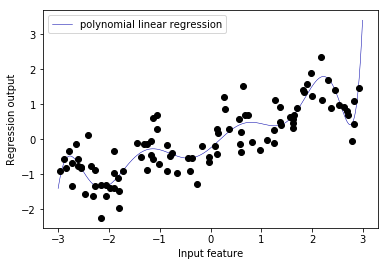

In [33]:
reg = LinearRegression().fit(X_poly, y)

line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

As a comparison, here is a kernel SVM model learned on the original data, without any transformation

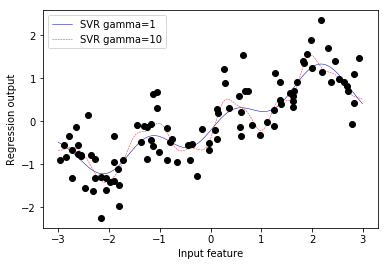

In [34]:
from sklearn.svm import SVR

for gamma in [1, 10]:
    svr = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svr.predict(line), label='SVR gamma={}'.format(gamma))

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

### Binning (Discretization)

Make linear models more powerful by splitting up a feature into multiple artificial features:
- Partition the feature values into a fixed number of bins  
- A data point will then be represented by which bin it falls into.
- Each bin becomes a new dimension

In [35]:
bins = np.linspace(-3, 3, 11)
print("bins: {}".format(bins))

bins: [-3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3. ]


Numpy's `digitize` maps each value to its corresponding bin. E.g. the first sample goes to bin nr. 4.

In [36]:
which_bin = np.digitize(X, bins=bins)
print("\nData points:\n", X[:5])
print("\nBin membership for data points:\n", which_bin[:5])


Data points:
 [[-0.753]
 [ 2.704]
 [ 1.392]
 [ 0.592]
 [-2.064]]

Bin membership for data points:
 [[ 4]
 [10]
 [ 8]
 [ 6]
 [ 2]]


#### Encoding data  with scikit-learn (`OneHotEncoder`)
- Scikit-learn offers a convenient `OneHotEncoder`
- Call `fit` to compute the internal parameters of the transformation
- Call `transform` to produce the transformed data. You can also run `fit_transform` to do both at once. 

!! Test data should _never_ be used to compute the preprocessing, because information about the test data will _leak_ into the training data, invalidating your model evaluation. Use a nested loop.

In [37]:
from sklearn.preprocessing import OneHotEncoder
# transform using the OneHotEncoder.
encoder = OneHotEncoder(sparse=False)
# encoder.fit finds the unique values that appear in which_bin
encoder.fit(which_bin)
# transform creates the one-hot encoding
X_binned = encoder.transform(which_bin)
print(X_binned[:5])

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [38]:
print("X_binned.shape: {}".format(X_binned.shape))

X_binned.shape: (100, 10)


Now we build a new linear regression model and a new decision tree model on the one-hot-encoded data.

Text(0.5,0,'Input feature')

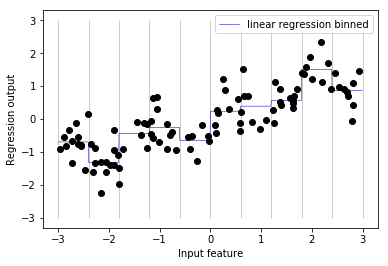

In [39]:
line_binned = encoder.transform(np.digitize(line, bins=bins))

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='linear regression binned')

plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(bins, -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")

### Interaction features

Another way to enrich a feature representation, particularly for linear models, is adding interaction features and polynomial features of the original data.

For instance: our linear model learned a constant value for each bin in the wave dataset. If we want a sloped linear model we need to allow interaction with another feature, e.g., the original feature. So let's add the original feature (the x-axis in the plot) back in. This leads to an 11-dimensional dataset:

In [40]:
X_combined = np.hstack([X, X_binned])
print(X_combined.shape)

(100, 11)


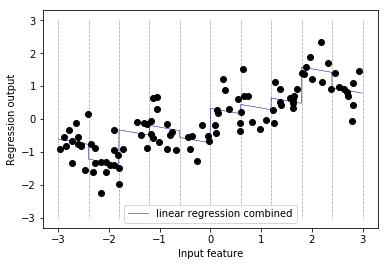

In [41]:

reg = LinearRegression().fit(X_combined, y)

line_combined = np.hstack([line, line_binned])
plt.plot(line, reg.predict(line_combined), label='linear regression combined')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.plot(X[:, 0], y, 'o', c='k')

### Product features

If we want a different slope per bin, we need a new _interaction feature_ (or _product feature_) that indicates in which bin a data point is in __and__ where it lies on the x-axis.

In [42]:
X_product = np.hstack([X_binned, X * X_binned])
print(X_product.shape)

(100, 20)


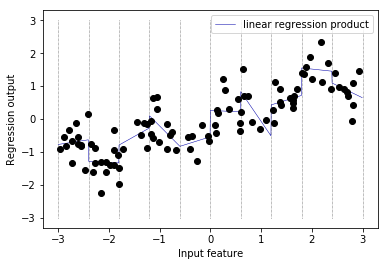

In [43]:
reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, reg.predict(line_product), label='linear regression product')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

### Non-linear transformations

There are other transformations that often prove useful for transforming certain features.

For instance, `log` or `exp` are very useful to better scale your data. This is useful for models that are sensitive to feature scales, such as linear models, SVMs and neural networks.

The functions log and exp can help by adjusting the relative scales, tranforming them to more Gaussian-like value distributions.

Here we generate some data that has a very non-normal (Poisson) distribution:

In [44]:
rnd = np.random.RandomState(0)
X_org = rnd.normal(size=(1000, 3))
w = rnd.normal(size=3)

X = rnd.poisson(10 * np.exp(X_org))
y = np.dot(X_org, w)

In [45]:
print("Number of feature appearances:\n{}".format(np.bincount(X[:, 0])))

Number of feature appearances:
[28 38 68 48 61 59 45 56 37 40 35 34 36 26 23 26 27 21 23 23 18 21 10  9 17
  9  7 14 12  7  3  8  4  5  5  3  4  2  4  1  1  3  2  5  3  8  2  5  2  1
  2  3  3  2  2  3  3  0  1  2  1  0  0  3  1  0  0  0  1  3  0  1  0  2  0
  1  1  0  0  0  0  1  0  0  2  2  0  1  1  0  0  0  0  1  1  0  0  0  0  0
  0  0  1  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0
  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]


Text(0.5,0,'Value')

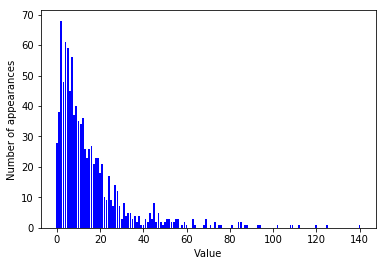

In [46]:
bins = np.bincount(X[:, 0])
plt.bar(range(len(bins)), bins, color='b')
plt.ylabel("Number of appearances")
plt.xlabel("Value")

This is something most linear models can’t handle very well:

In [48]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
score = Ridge().fit(X_train, y_train).score(X_test, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.622


Applying a logarithmic transformation can help to create a more normal (Gaussian) distribution

In [49]:
# We actually compute log(x+1) to avoid the occurrence of log(0)
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)

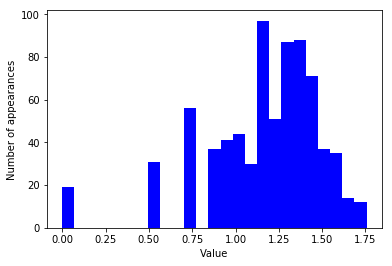

In [50]:
plt.hist(np.log(X_train_log[:, 0] + 1), bins=25, color='b')
plt.ylabel("Number of appearances")
plt.xlabel("Value");

And our Ridge regressor now performs a lot better.

In [51]:
score = Ridge().fit(X_train_log, y_train).score(X_test_log, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.875


Finding the transformation that works best for each combination of dataset and model is somewhat of an art.

## Automatic Feature Selection

When adding new features, or with high-dimensional datasets in general, it can be a good idea to reduce the number of features to only the most useful ones, and discard the rest.
- Simpler models that generalize better
- Help algorithms that are sensitive to the number of features (e.g. kNN).

#### Univariate statistics (ANOVA)

We want to keep the features for which there is statistically significant relationship between it and the target.
In the case of classification, this is also known as analysis of variance (ANOVA). These test consider each feature individually (they are univariate), and are completely independent of the model that you might want to apply afterwards.
The result will be a p-value for each feature (lower is better). 

In scikit-learn":
- `SelectKBest` will only keep the $k$ features with the lowest p values. 
- `SelectPercentile` selects a fixed percentage of features. 

To test these methods, we'll take the `breast_cancer` dataset, and add 50 random noise features. The feature selector should be able to remove at least these noise features.

In [52]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)
# use f_classif (the default) and SelectPercentile to select 50% of features:
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set:
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


We can retrieve which features were selected with `get_support`, and visualize the selected (black) and removed (white) features. `SelectPercentile` removed most of the noise features, but not perfectly.

Text(0.5,0,'Sample index')

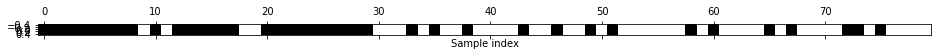

In [53]:
mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

As usual, we need to check how the transformation affects the performance of our learning algorithms.

In [54]:
from sklearn.linear_model import LogisticRegression

# transform test data:
X_test_selected = select.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(
        lr.score(X_test_selected, y_test)))

Score with all features: 0.930
Score with only selected features: 0.940


#### Model-based Feature Selection
Model-based feature selection uses a supervised machine learning model to judge the importance of each feature, and keeps only the most important ones. Compared to ANOVA, they consider all features together, and are thus able to capture interactions: a feature may be more (or less) informative in combination with others.

The supervised model that is used for feature selection doesn’t need to be the same model that is used for the final supervised modeling, it only needs to be able to measure the (perceived) importance for each feature:

- Decision tree–based models return a `feature_importances_` attribute
- Linear models return coefficients, whose absolute values also reflect feature importance 

In scikit-learn, we can do this using `SelectFromModel`. It requires a model and a threshold. Threshold='median' means that the median observed feature importance will be the threshold, which will remove 50% of the features.

We've seen before how RandomForests return good estimates of feature importance:

In [55]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

In [56]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


Text(0.5,0,'Sample index')

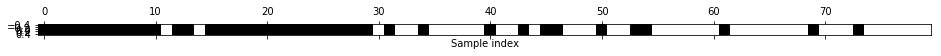

In [57]:
mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

All but two of the original features were selected, and most of the noise features removed. Our linear model trained on the selected features also performs quite a bit better.

In [58]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


#### Iterative feature selection

Instead of building a model to remove many features at once, we can also just ask it to remove the worst feature, then retrain, remove another feature, etc. This is known as _recursive feature elimination_ (RFE).

Vice versa, we couls also ask it to iteratively add one feature at a time. This is called _forward selection_.

In both cases, we need to define beforehand how many features to select. When this is unknown, one often considers this as an additional hyperparameter of the whole process (pipeline) that needs to be optimized.

Text(0.5,0,'Sample index')

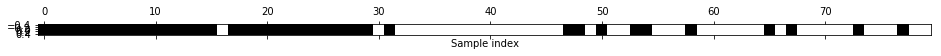

In [59]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)

select.fit(X_train, y_train)
# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

In [60]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


In [61]:
print("Test score: {:.3f}".format(select.score(X_test, y_test)))

Test score: 0.951


Automatic feature selection can be helpful when:

- You expect some inputs to be uninformative, and your model does not select features internally (as tree-based models do)
- You need to speed up prediction without loosing much accuracy
- You want a more interpretable model (with fewer variables)

## Scaling

When the features have different scales (their values range between very different minimum and maximum values), it makes sense to scale them to the same range. Otherwise, one feature will overpower the others, expecially when raised to the $n$th power.

- We can rescale features between 0 and 1 using MinMaxScaler. 
- Remember to `fit_transform` the training data, then `transform` the test data

In [62]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, 
                                                    random_state=0)

# rescale data:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Several scaling techniques are available:
- `StandardScaler` rescales all features to mean=0 and variance=1
    - Does not ensure and min/max value
- `RobustScaler` uses the median and quartiles
    - Median m: half of the values < m, half > m
    - Lower Quartile lq: 1/4 of values < lq
    - Upper Quartile uq: 1/4 of values > uq
    - Ignores _outliers_, brings all features to same scale
- `MinMaxScaler` brings all feature values between 0 and 1
- `Normalizer` scales data such that the feature vector has Euclidean length 1
    - Projects data to the unit circle
    - Used when only the direction/angle of the data matters

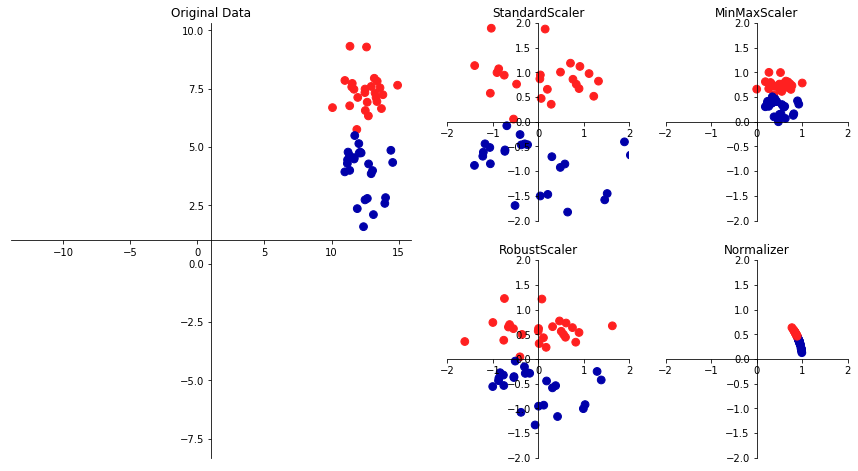

In [63]:
mglearn.plots.plot_scaling()

### Applying scaling transformations
- Lets apply a scaling transformation _manually_, then use it to train a learning algorithm
- First, split the data in training and test set

In [64]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    random_state=1)

- Next, we `fit` the preprocessor on the __training data__
    - This computes the necessary transformation parameters
    - For `MinMaxScaler`, these are the min/max values for every feature

In [65]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

* After fitting, we can `transform` the training and test data 

In [66]:
# transform training data
X_train_scaled = scaler.transform(X_train)
# print dataset properties before and after scaling
print("per-feature minimum before scaling:\n {}".format(X_train.min(axis=0)))
print("per-feature maximum before scaling:\n {}".format(X_train.max(axis=0)))
print("per-feature minimum after scaling:\n {}".format(
        X_train_scaled.min(axis=0)))
print("per-feature maximum after scaling:\n {}".format(
        X_train_scaled.max(axis=0)))

per-feature minimum before scaling:
 [   6.981    9.71    43.79   143.5      0.053    0.019    0.       0.
    0.106    0.05     0.115    0.36     0.757    6.802    0.002    0.002
    0.       0.       0.01     0.001    7.93    12.02    50.41   185.2
    0.071    0.027    0.       0.       0.157    0.055]
per-feature maximum before scaling:
 [   28.11     39.28    188.5    2501.        0.163     0.287     0.427
     0.201     0.304     0.096     2.873     4.885    21.98    542.2
     0.031     0.135     0.396     0.053     0.061     0.03     36.04
    49.54    251.2    4254.        0.223     0.938     1.17      0.291
     0.577     0.149]
per-feature minimum after scaling:
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
per-feature maximum after scaling:
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [67]:
# transform test data
X_test_scaled = scaler.transform(X_test)
# print test data properties after scaling
print("per-feature minimum after scaling:\n{}".format(X_test_scaled.min(axis=0)))
print("per-feature maximum after scaling:\n{}".format(X_test_scaled.max(axis=0)))

per-feature minimum after scaling:
[ 0.034  0.023  0.031  0.011  0.141  0.044  0.     0.     0.154 -0.006
 -0.001  0.006  0.004  0.001  0.039  0.011  0.     0.    -0.032  0.007
  0.027  0.058  0.02   0.009  0.109  0.026  0.     0.    -0.    -0.002]
per-feature maximum after scaling:
[ 0.958  0.815  0.956  0.894  0.811  1.22   0.88   0.933  0.932  1.037
  0.427  0.498  0.441  0.284  0.487  0.739  0.767  0.629  1.337  0.391
  0.896  0.793  0.849  0.745  0.915  1.132  1.07   0.924  1.205  1.631]


* After scaling the test data, the values are not exactly between 0 and 1
* This is correct: we used the min/max values from the training data only
* We are still interested in how well our preprocessing+learning model generalizes from the training to the test data

- Remember to `fit` and `transform` on the training data, then `transform` the test data

* 2nd figure: `fit` on training set, `transform` on training and test set
* 3rd figure: `fit` and `transform` on the training data
    * Test data points nowhere near same training data points
    * Trained model will have a hard time generalizing correctly

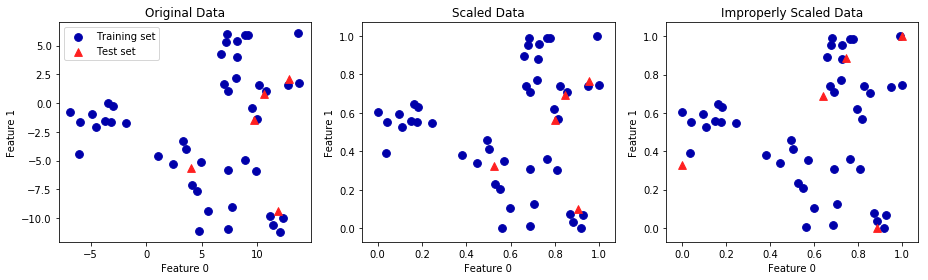

In [68]:
from sklearn.datasets import make_blobs
# make synthetic data
X, _ = make_blobs(n_samples=50, centers=5, random_state=4, cluster_std=2)
# split it into training and test set
X_train, X_test = train_test_split(X, random_state=5, test_size=.1)

# plot the training and test set
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
axes[0].scatter(X_train[:, 0], X_train[:, 1],
                c=mglearn.cm2(0), label="Training set", s=60)
axes[0].scatter(X_test[:, 0], X_test[:, 1], marker='^',
                c=mglearn.cm2(1), label="Test set", s=60)
axes[0].legend(loc='upper left')
axes[0].set_title("Original Data")

# scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# visualize the properly scaled data
axes[1].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1],
                c=mglearn.cm2(0), label="Training set", s=60)
axes[1].scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], marker='^',
                c=mglearn.cm2(1), label="Test set", s=60)
axes[1].set_title("Scaled Data")

# rescale the test set separately
# so that test set min is 0 and test set max is 1
# DO NOT DO THIS! For illustration purposes only
test_scaler = MinMaxScaler()
test_scaler.fit(X_test)
X_test_scaled_badly = test_scaler.transform(X_test)

# visualize wrongly scaled data
axes[2].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1],
                c=mglearn.cm2(0), label="training set", s=60)
axes[2].scatter(X_test_scaled_badly[:, 0], X_test_scaled_badly[:, 1],
                marker='^', c=mglearn.cm2(1), label="test set", s=60)
axes[2].set_title("Improperly Scaled Data")

for ax in axes:
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
fig.tight_layout()

* Note: you can fit and transform the training together with `fit_transform`
* To transform the test data, you always need to `fit` on the training data and `transform` the test data

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# calling fit and transform in sequence (using method chaining)
X_scaled = scaler.fit(X).transform(X)
# same result, but more efficient computation
X_scaled_d = scaler.fit_transform(X)

### How great is the effect of scaling?
* First, we train the (linear) SVM without scaling

In [70]:
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    random_state=0)

svm = LinearSVC()
svm.fit(X_train, y_train)
print("Test set accuracy: {:.2f}".format(svm.score(X_test, y_test)))

Test set accuracy: 0.94


* With scaling, we get a much better model

In [71]:
# preprocessing using 0-1 scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# learning an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scoring on the scaled test set
print("Scaled test set accuracy: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Scaled test set accuracy: 0.97


### Scaling for polynomial regression
After scaling, we extract polynomial features and interactions up to a degree of 2. Note how we `fit` the `PolynomialFeatures` only on the training data and then apply it (`transform`) on both the training and test data.

`PolynomialFeatures` will add a new features for each possible interaction (product) of up to 2 input features, including the products of a feature with itself (the squares). Hence, $\frac{13!}{11!  2!}$ + 13 + 13 features total.


In [72]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

# rescale data:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [73]:
poly = PolynomialFeatures(degree=2).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_poly.shape: {}".format(X_train_poly.shape))

X_train.shape: (379, 13)
X_train_poly.shape: (379, 105)


The exact correspondence between input and output features can be found using the get_feature_names method:

In [74]:
print("Polynomial feature names:\n{}".format(poly.get_feature_names()))

Polynomial feature names:
['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12', 'x8^2', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x9^2', 'x9 x10', 'x9 x11', 'x9 x12', 'x10^2', 'x10 x11', 'x10 x12', 'x11^2', 'x11 x12', 'x12^2']


Let’s compare the performance of a linear model (Ridge regression) on the data with and without interactions:

In [75]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(
        ridge.score(X_test_scaled, y_test)))
ridge = Ridge().fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(
        ridge.score(X_test_poly, y_test)))

Score without interactions: 0.621
Score with interactions: 0.753


Clearly, the interactions and polynomial features gave us a good boost in performance when using Ridge. When using a more complex model like a random forest, the story is a bit different, though:

In [76]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100).fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(
        rf.score(X_test_scaled, y_test)))
rf = RandomForestRegressor(n_estimators=100).fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(rf.score(X_test_poly, y_test)))

Score without interactions: 0.796
Score with interactions: 0.765


The random forest does not benefit from the interaction features, in fact, performance decreases...

Adding polynomials is typically good for linear models, but not a cure-for-all. Always evaluate the performance of models when adding preprocessing steps.

* What if we want the cross-validated evaluation?
    - Apply scaling on every fold independently?

## Building Pipelines
* In scikit-learn, a `pipeline` combines multiple processing _steps_ in a single estimator
* All but the last step should be transformer (have a `transform` method)
    * The last step can be a transformer too (e.g. Scaler+PCA)
* It has a `fit`, `predict`, and `score` method, just like any other learning algorithm
* Pipelines are built as a list of steps, which are (name, algorithm) tuples
    * The name can be anything you want, but can't contain `'__'`
    * We use `'__'` to refer to the hyperparameters, e.g. `svm__C`
* Let's build, train, and score a `MinMaxScaler` + `LinearSVC` pipeline:

In [77]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", LinearSVC())])

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    random_state=1)
pipe.fit(X_train, y_train)
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


* Now with cross-validation:

In [78]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe, cancer.data, cancer.target)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [ 0.984  0.953  0.979]
Average cross-validation score: 0.97


* We can retrieve the trained SVM by querying the right step indices

In [79]:
pipe.fit(X_train, y_train)
print("SVM component: {}".format(pipe.steps[1][1]))

SVM component: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


* Or we can use the `named_steps` dictionary

In [80]:
print("SVM component: {}".format(pipe.named_steps['svm']))

SVM component: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


* When you don't need specific names for specific steps, you can use `make_pipeline`
    * Assigns names to steps automatically

In [81]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", LinearSVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), LinearSVC(C=100))
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('linearsvc', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]


Visualization of a pipeline `fit` and `predict`

![pipeline_illustration](images/07_pipelines.png)